Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

sess = tf.compat.v1.Session(config = config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [2]:
import pathlib
#import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


In [4]:
cd drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration

/content/drive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Train")
data_dir_test = pathlib.Path('Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                              'Train', 
                                                               batch_size=batch_size, 
                                                               image_size=(img_height, img_width),
                                                               shuffle=True, 
                                                               seed=123, 
                                                               validation_split=0.2, 
                                                               subset = 'training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                                            'Train', 
                                                             batch_size=batch_size, 
                                                             image_size=(img_height, img_width),
                                                             shuffle=True, 
                                                             seed=123,
                                                             validation_split=0.2, 
                                                             subset = 'validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

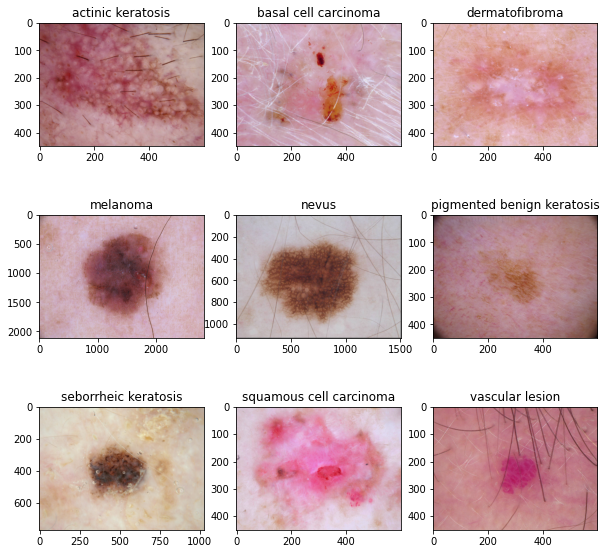

In [11]:
import matplotlib.pyplot as plt
import cv2

images = []
images.append(cv2.imread('Train/actinic keratosis/ISIC_0025780.jpg'))
images.append(cv2.imread('Train/basal cell carcinoma/ISIC_0024504.jpg'))
images.append(cv2.imread('Train/dermatofibroma/ISIC_0025223.jpg'))
images.append(cv2.imread('Train/melanoma/ISIC_0000139.jpg'))
images.append(cv2.imread('Train/nevus/ISIC_0000019.jpg'))
images.append(cv2.imread('Train/pigmented benign keratosis/ISIC_0024435.jpg'))
images.append(cv2.imread('Train/seborrheic keratosis/ISIC_0010810.jpg'))
images.append(cv2.imread('Train/squamous cell carcinoma/ISIC_0024710.jpg'))
images.append(cv2.imread('Train/vascular lesion/ISIC_0024475.jpg'))

plt.figure(figsize = (10,10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i][:,:,::-1])
    plt.title(class_names[i])
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
from keras import regularizers

### Your code goes here
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(scale=1./255))
model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape = (img_height, img_width, 3), activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512, kernel_regularizer = regularizers.l2(0.01), activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9, activation = 'softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
model.build((None, img_height, img_width, 3))
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 180, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 178, 178, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 178, 178, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 89, 89, 32)        0

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 1119s 4s/step - loss: 15.5876 - accuracy: 0.2769 - val_loss: 13.2363 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 3s 53ms/step - loss: 11.4428 - accuracy: 0.4445 - val_loss: 14.2187 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 3s 54ms/step - loss: 11.0081 - accuracy: 0.5177 - val_loss: 13.8125 - val_accuracy: 0.1521
Epoch 4/20
56/56 [==============================] - 3s 54ms/step - loss: 10.6269 - accuracy: 0.5682 - val_loss: 13.5641 - val_accuracy: 0.1812
Epoch 5/20
56/56 [==============================] - 3s 53ms/step - loss: 10.3737 - accuracy: 0.5647 - val_loss: 14.1861 - val_accuracy: 0.1790
Epoch 6/20
56/56 [==============================] - 3s 54ms/step - loss: 10.0637 - accuracy: 0.5934 - val_loss: 13.5387 - val_accuracy: 0.1879
Epoch 7/20
56/56 [==============================] - 3s 54ms/step - loss: 9.7815 - accuracy: 0.6423 - val_loss: 12.6193 - val_accuracy: 0.2662

### Visualizing training results

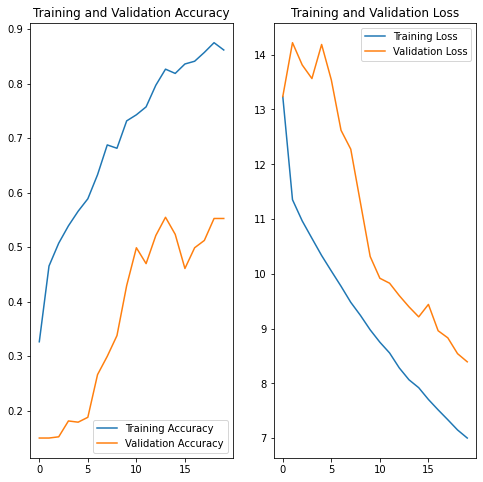

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
#### The Training Accuracy of the Model is 0.8686 and Validation Accuracy of the Model is 0.5526 after 20 epochs
#### The Training Loss of the Model is 7.0204 and Validation Loss of the Model is 8.3943 after 20 epochs
#### So, the Model has overfit to a large extent as there are huge differences between Training and Validation Accuracies & Training and Validation Losses

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                          width_shift_range=0.2,
                                                          height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                                          horizontal_flip=True, validation_split=0.2, dtype=None
                                                          )
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)
train_ds = train_datagen.flow_from_directory(
                                              'Train',
                                              batch_size = batch_size,
                                              target_size = (img_height, img_width),
                                              subset = 'training',
                                              class_mode = 'categorical'
                                            )
val_ds = validation_datagen.flow_from_directory(
                                                 'Train',
                                                  shuffle = True,
                                                  batch_size = batch_size,
                                                  target_size = (img_height, img_width),
                                                  subset='validation',
                                                  class_mode='categorical'
                                               )

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


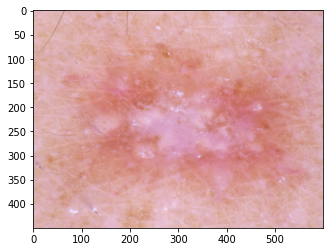

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

img = tf.keras.preprocessing.image.load_img('Train/dermatofibroma/ISIC_0025223.jpg')
_img = tf.keras.preprocessing.image.img_to_array(img)
samples = np.expand_dims(_img, 0)
plt.imshow(img) # original image

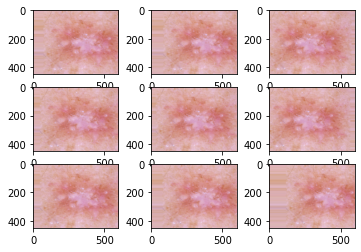

In [21]:
# width shift augmentation
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2)
it = data_gen.flow(samples, batch_size=1)
for i in range(9):
    plt.subplot(330+1+i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

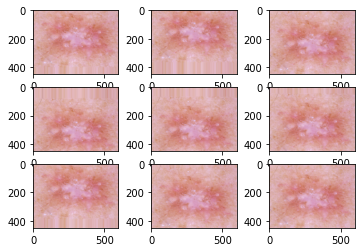

In [22]:
# height shift augmentation
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(height_shift_range=0.2)
it = data_gen.flow(samples, batch_size=1)
for i in range(9):
    plt.subplot(330+1+i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

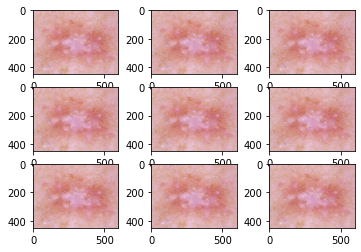

In [23]:
# shear range augmentation
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.2)
it = data_gen.flow(samples, batch_size=1)
for i in range(9):
    plt.subplot(330+1+i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

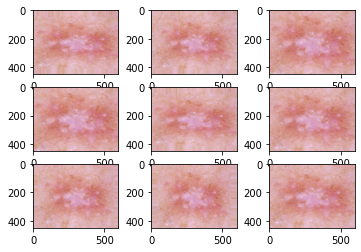

In [24]:
# zoom range augmentation
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2)
it = data_gen.flow(samples, batch_size=1)
for i in range(9):
    plt.subplot(330+1+i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

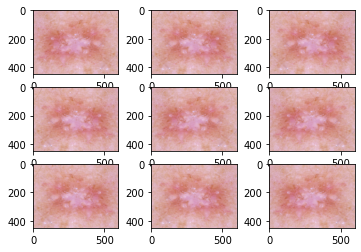

In [25]:
# horizontal flip augmentation
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip = True)
it = data_gen.flow(samples, batch_size=1)
plt.title('Horizontal Flip')
for i in range(9):
    plt.subplot(330+1+i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

### Todo:
### Create the model, compile and train the model


In [26]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(scale=1./255))
model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape = (img_height, img_width, 3), activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512, kernel_regularizer = regularizers.l2(0.01), activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9, activation = 'softmax'))

### Compiling the model

In [27]:
## Your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [28]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 45s 788ms/step - loss: 15.4446 - accuracy: 0.2568 - val_loss: 12.7538 - val_accuracy: 0.1689
Epoch 2/20
57/57 [==============================] - 44s 767ms/step - loss: 11.5372 - accuracy: 0.3975 - val_loss: 14.7405 - val_accuracy: 0.1689
Epoch 3/20
57/57 [==============================] - 44s 770ms/step - loss: 11.2238 - accuracy: 0.4476 - val_loss: 13.6431 - val_accuracy: 0.1712
Epoch 4/20
57/57 [==============================] - 44s 769ms/step - loss: 11.0502 - accuracy: 0.4247 - val_loss: 13.4322 - val_accuracy: 0.2410
Epoch 5/20
57/57 [==============================] - 44s 774ms/step - loss: 10.6426 - accuracy: 0.4993 - val_loss: 12.7039 - val_accuracy: 0.2500
Epoch 6/20
57/57 [==============================] - 44s 769ms/step - loss: 10.5060 - accuracy: 0.4821 - val_loss: 12.9011 - val_accuracy: 0.2635
Epoch 7/20
57/57 [==============================] - 44s 776ms/step - loss: 10.2334 - accuracy: 0.4838 - val_loss: 11.3547 - val_ac

### Visualizing the results

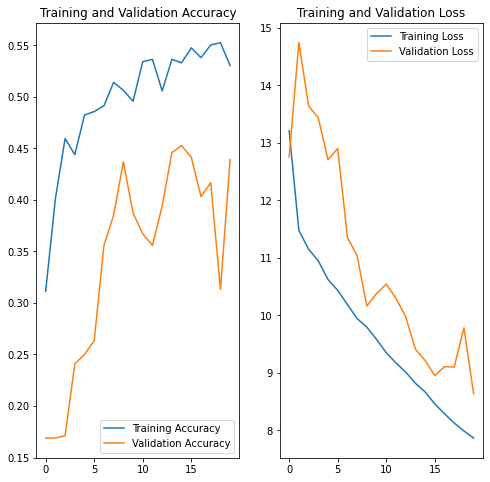

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
##### The Training Accuracy of the Model is 0.5263 and Validation Accuracy of the Model is 0.4392 after 20 epochs
##### The Training Loss of the Model is 7.9172 and Validation Loss of the Model is 8.6379 after 20 epochs
##### As compared to the previous model, augmentation has helped reducing the degree of over-fitting but, overall performance has not improved

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [30]:
## Your code goes here.
proportionate_number_of_samples = []
for class_name in class_names:
    dir = pathlib.Path("Train/" + class_name)
    print('Proportionate number of samples belonging to class, '+ class_name + ' = ', len(list(dir.glob('*.jpg')))/image_count_train)
    proportionate_number_of_samples.append(len(list(dir.glob('*.jpg')))/image_count_train)

Proportionate number of samples belonging to class, actinic keratosis =  0.05091558731576597
Proportionate number of samples belonging to class, basal cell carcinoma =  0.16793211255024565
Proportionate number of samples belonging to class, dermatofibroma =  0.04242965609647164
Proportionate number of samples belonging to class, melanoma =  0.19562304600267977
Proportionate number of samples belonging to class, nevus =  0.15944618133095131
Proportionate number of samples belonging to class, pigmented benign keratosis =  0.20634211701652524
Proportionate number of samples belonging to class, seborrheic keratosis =  0.03439035283608754
Proportionate number of samples belonging to class, squamous cell carcinoma =  0.08083966056275123
Proportionate number of samples belonging to class, vascular lesion =  0.062081286288521664


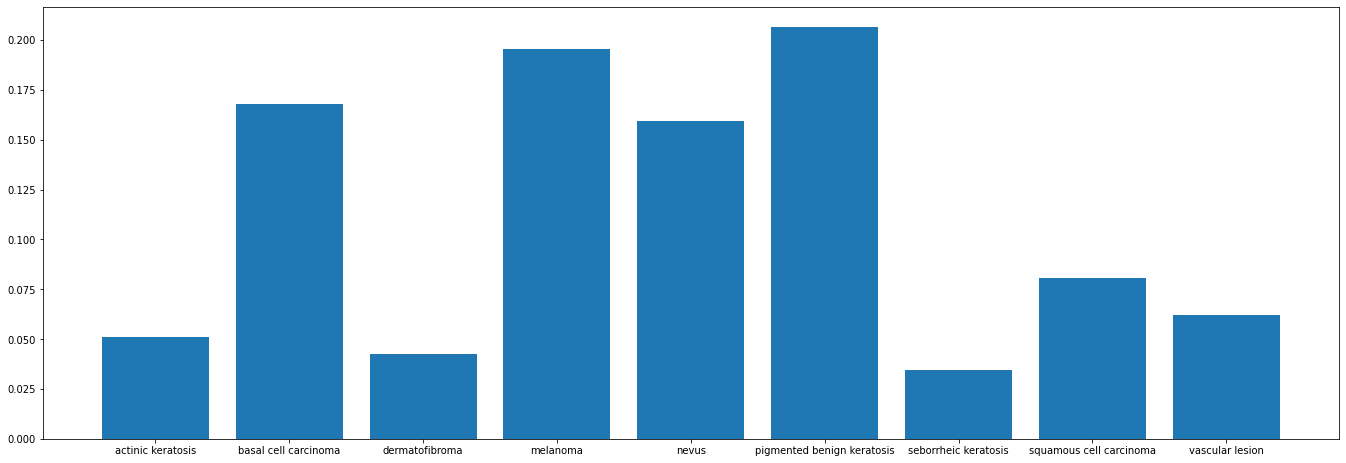

In [31]:
fig = plt.figure(figsize=(18, 6))
ax = fig.add_axes([0,0,1,1])
ax.bar(class_names, proportionate_number_of_samples)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### **seborrheic keratosis** has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
#### **pigmented benign keratosis**, **melanoma**, **basal cell carcinoma** and **nevus** are the classes that dominate the data in terms of proportionate number of samples having proportions more than 0.15


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [33]:
path_to_training_dataset="Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F442B0E1CF8>: 100%|██████████| 500/500 [00:18<00:00, 26.96 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F442B1E2B00>: 100%|██████████| 500/500 [00:18<00:00, 26.87 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F442BE634A8>:   0%|          | 1/500 [00:00<00:51,  9.76 Samples/s]

Initialised with 95 image(s) found.
Output directory set to Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F442A3169E8>: 100%|██████████| 500/500 [00:18<00:00, 27.01 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7F442B23DD30>: 100%|██████████| 500/500 [01:25<00:00,  5.87 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F442B180780>: 100%|██████████| 500/500 [01:26<00:00,  5.79 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F442B031240>: 100%|██████████| 500/500 [00:19<00:00, 26.18 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F442A055438>:   0%|          | 1/500 [00:00<01:30,  5.54 Samples/s]

Initialised with 77 image(s) found.
Output directory set to Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F442A0BB710>: 100%|██████████| 500/500 [00:40<00:00, 12.29 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F442B20F908>: 100%|██████████| 500/500 [00:18<00:00, 26.64 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F442C38F6A0>: 100%|██████████| 500/500 [00:18<00:00, 26.98 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
from glob import glob

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Train/nevus/output/nevus_original_ISIC_0024511.jpg_0ae5510a-11b6-40cd-b8c6-c730dfc3abd9.jpg',
 'Train/nevus/output/nevus_original_ISIC_0000061.jpg_0e60b8b1-1ddb-4c7f-b745-67ec2d975a00.jpg',
 'Train/nevus/output/nevus_original_ISIC_0000373.jpg_e4a6830f-c6e1-4bf4-a57c-d2844892c45e.jpg',
 'Train/nevus/output/nevus_original_ISIC_0025825.jpg_a8e34119-9582-4e75-86f3-8f80d1712f62.jpg',
 'Train/nevus/output/nevus_original_ISIC_0000370.jpg_277cff90-27d9-4477-a615-54193b82e186.jpg',
 'Train/nevus/output/nevus_original_ISIC_0000373.jpg_e4acb2f6-4e7e-4950-9e52-f477744b9f8f.jpg',
 'Train/nevus/output/nevus_original_ISIC_0000543.jpg_4ed1b309-b9dc-4550-bb7b-dec3f4c01107.jpg',
 'Train/nevus/output/nevus_original_ISIC_0000501.jpg_0bad220b-1004-4084-a1ff-4992430e68b9.jpg',
 'Train/nevus/output/nevus_original_ISIC_0029460.jpg_cdf86578-9fe6-4c86-ae59-d66a7e206208.jpg',
 'Train/nevus/output/nevus_original_ISIC_0000235.jpg_19c2bc5a-cdf9-4fb7-a6d8-6039d45d978b.jpg',
 'Train/nevus/output/nevus_original_ISIC

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [37]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [38]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*/*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*/*.jpg'))]

dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [40]:
df2.head()

,Path,Label
0,Train/nevus/output/nevus_original_ISIC_0024511...,nevus
1,Train/nevus/output/nevus_original_ISIC_0000061...,nevus
2,Train/nevus/output/nevus_original_ISIC_0000373...,nevus
3,Train/nevus/output/nevus_original_ISIC_0025825...,nevus
4,Train/nevus/output/nevus_original_ISIC_0000370...,nevus


In [41]:
new_df['Label'].value_counts()

Train                         2239
dermatofibroma                 500
seborrheic keratosis           500
squamous cell carcinoma        500
pigmented benign keratosis     500
nevus                          500
actinic keratosis              500
melanoma                       500
vascular lesion                500
basal cell carcinoma           500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [42]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [43]:
data_dir_train = 'Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed = 123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [45]:
## your code goes here

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(scale=1./255))
model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape = (img_height, img_width, 3), activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512, kernel_regularizer = regularizers.l2(0.01), activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9, activation = 'softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [46]:
## your code goes here
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [47]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 44s 247ms/step - loss: 13.3345 - accuracy: 0.3013 - val_loss: 13.4902 - val_accuracy: 0.0980
Epoch 2/30
169/169 [==============================] - 42s 244ms/step - loss: 10.7302 - accuracy: 0.4668 - val_loss: 12.7142 - val_accuracy: 0.1893
Epoch 3/30
169/169 [==============================] - 42s 241ms/step - loss: 9.9304 - accuracy: 0.5405 - val_loss: 10.0636 - val_accuracy: 0.4529
Epoch 4/30
169/169 [==============================] - 42s 243ms/step - loss: 9.2163 - accuracy: 0.6097 - val_loss: 9.2937 - val_accuracy: 0.5835
Epoch 5/30
169/169 [==============================] - 42s 242ms/step - loss: 8.5583 - accuracy: 0.6701 - val_loss: 9.0321 - val_accuracy: 0.5115
Epoch 6/30
169/169 [==============================] - 42s 244ms/step - loss: 7.9706 - accuracy: 0.7136 - val_loss: 7.9249 - val_accuracy: 0.6607
Epoch 7/30
169/169 [==============================] - 42s 242ms/step - loss: 7.4320 - accuracy: 0.7535 - val_loss: 7.2101 - v

#### **Todo:**  Visualize the model results

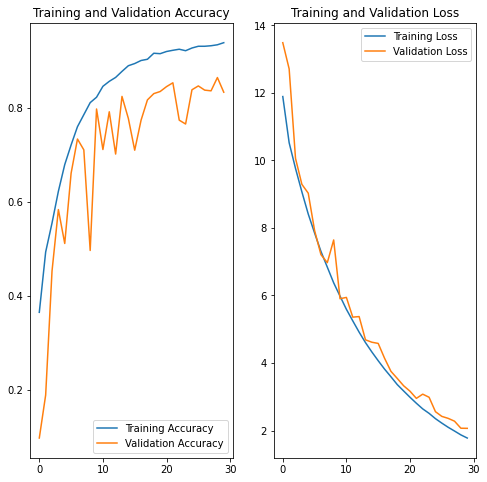

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
##### The Training Accuracy of the model is 0.9368 and Validation Accuracy of the model is 0.8330 after 30 epochs
##### The Training Loss of the model is 1.8013 and Validation Loss of the model is 2.0641 after 30 epochs
##### Yes, Class Rebalance did help in terms of model performance enhancement as the Validation Accuracy shot up to 83.3% from being in the range of 45-55% in previous models. But, the issue of over-fitting is not resolved as there is sustained over-fitting when compared to Model 2